# Phase 4: 長期改善の分析と検証

改善分析レポート（`.tmp/improvement-analysis.md`）で特定されたPhase 4項目を調査・検証する。

### Phase 1-3 完了状況

Phase 1-3 の実装が完了し、モデルは以下の状態にある:

- **特徴量数**: 33 → 49（Phase 1: +1, Phase 2: +10, Phase 3: +5）
- **目的関数**: NDCG@3 → NDCG@1（Phase 3: 1着予測に特化）
- **Best NDCG@1**: 0.6714
- **実運用精度（直近7日平均）**: 1着的中率 47.4%、三連単 3.5%
- **全期間集計（22日分）**: 1着的中率 45.3%、三連単 4.0%
- **フィードバックループ**: JSON メトリクス出力、7日移動平均アラート、backfill 機能が稼働中

## 調査項目

1. **決まり手予測の中間モデル** — 逃げ/差し/まくりの予測で1着予測を補完
2. **選手統計のスライディングウィンドウ化** — 静的統計（2016-2024）→ 動的計算への移行
3. **定期再学習パイプライン** — CI/CDでの自動再学習とデプロイ
4. **モデルバージョン管理の体系化** — メタデータ付きモデル管理とロールバック
5. **データストレージのParquet移行** — CSV→Parquet変換によるI/O高速化
6. **風向エンコーディング改善** — results(8方位テキスト) vs previews(4コード) の不整合修正

## 0. セットアップ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import os
import time
from pathlib import Path
from collections import defaultdict

matplotlib.rcParams['font.family'] = 'Hiragino Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent
print(f'repo_root: {repo_root}')

STADIUM_CODE_TO_NAME = {
    1: '桐生', 2: '戸田', 3: '江戸川', 4: '平和島', 5: '多摩川',
    6: '浜名湖', 7: '蒲郡', 8: '常滑', 9: '津', 10: '三国',
    11: 'びわこ', 12: '住之江', 13: '尼崎', 14: '鳴門', 15: '丸亀',
    16: '児島', 17: '宮島', 18: '徳山', 19: '下関', 20: '若松',
    21: '芦屋', 22: '福岡', 23: '唐津', 24: '大村',
}
SHORT_NAME_TO_CODE = {v: k for k, v in STADIUM_CODE_TO_NAME.items()}

repo_root: /Users/mahiguch/dev/boatrace/data


In [2]:
def reshape_results(results_df):
    """ワイド形式のresultsをロング形式に変換"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回',
                 'レース名', '距離(m)', '天候', '風向', '風速(m)', '波の高さ(cm)', '決まり手']
    race_cols = [c for c in race_cols if c in results_df.columns]
    frames = []
    for n in range(1, 7):
        prefix = f'{n}着_'
        boat_cols = [c for c in results_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = results_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['着順'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

def reshape_programs(programs_df):
    """ワイド形式のprogramsをロング形式に変換"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回',
                 'レース名', '距離(m)', '電話投票締切予定']
    race_cols = [c for c in race_cols if c in programs_df.columns]
    frames = []
    for n in range(1, 7):
        prefix = f'{n}枠_'
        boat_cols = [c for c in programs_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = programs_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['枠'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

print('ヘルパー関数定義完了')

ヘルパー関数定義完了


In [3]:
# モデルとデータの読み込み
model_path = repo_root / 'models' / 'program_models_v2.pkl'
with open(model_path, 'rb') as f:
    models = pickle.load(f)

player_stats = models.get('_player_stats')
stadium_player_stats = models.get('_stadium_player_stats')
ensemble_weights = models.get('_ensemble_weights', (0.7, 0.2, 0.1))

print(f'アンサンブル重み: {ensemble_weights}')
print(f'player_stats: {player_stats.shape if player_stats is not None else "None"}')
print(f'stadium_player_stats: {stadium_player_stats.shape if stadium_player_stats is not None else "None"}')

if player_stats is not None:
    print(f'\nplayer_stats columns: {list(player_stats.columns)}')
    print(f'選手数: {len(player_stats)}')
    print(player_stats.describe().round(3))

アンサンブル重み: (0.7, 0.2, 0.1)
player_stats: (2064, 5)
stadium_player_stats: (43754, 5)

player_stats columns: ['登録番号', '履歴_平均着順', '履歴_1着率', '履歴_出走回数', 'イン1着率']
選手数: 2064
           登録番号   履歴_平均着順    履歴_1着率   履歴_出走回数     イン1着率
count  2064.000  2064.000  2064.000  2064.000  1963.000
mean   4300.700     3.718     0.140  1089.830     0.462
std     672.092     0.602     0.073   587.982     0.165
min    2014.000     2.333     0.000     1.000     0.000
25%    3774.500     3.268     0.091   553.750     0.361
50%    4339.500     3.662     0.130  1222.000     0.473
75%    4874.250     3.997     0.190  1581.750     0.582
max    5391.000     6.000     0.396  2242.000     1.000


---
## 1. 決まり手予測の中間モデル

### 背景
ボートレースの「決まり手」は逃げ/差し/まくりの3種類。
逃げ（1コースの選手がそのまま逃げ切り）が全体の約52%を占め、
決まり手が分かれば1着をほぼ確定できる（逃げ→1号艇が98%）。

決まり手を中間変数として予測するモデルを構築し、
最終予測の精度向上を図る。

In [4]:
# 決まり手データの分析
results_dfs = []
for year in ['2024', '2025']:
    for month in range(1, 13):
        res_dir = repo_root / 'data' / 'results' / year / f'{month:02d}'
        if not res_dir.exists():
            continue
        for f in sorted(res_dir.glob('*.csv')):
            try:
                results_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass

results_all = pd.concat(results_dfs, ignore_index=True)
print(f'結果データ: {len(results_all)}レース ({len(results_dfs)}日分)')
print(f'\n=== 決まり手の分布 ===')
kimarite_dist = results_all['決まり手'].value_counts(dropna=False)
for k, v in kimarite_dist.items():
    pct = v / len(results_all) * 100
    print(f'  {k}: {v} ({pct:.1f}%)')

print(f'\nNaN率: {results_all["決まり手"].isna().mean()*100:.1f}%')

結果データ: 109639レース (731日分)

=== 決まり手の分布 ===
  逃げ: 57411 (52.4%)
  差し: 26948 (24.6%)
  まくり: 17013 (15.5%)
  nan: 8267 (7.5%)

NaN率: 7.5%


In [5]:
# 決まり手と1着艇番の関係
results_long = reshape_results(results_all)
first_place = results_long[results_long['着順'] == 1].copy()
first_place['艇番'] = pd.to_numeric(first_place['艇番'], errors='coerce')

# 決まり手ごとの1着艇番の分布
print('=== 決まり手別: 1着艇番の分布 ===')
for kimarite in ['逃げ', '差し', 'まくり']:
    subset = first_place[first_place['決まり手'] == kimarite]
    if len(subset) == 0:
        continue
    boat_dist = subset['艇番'].value_counts().sort_index()
    print(f'\n{kimarite} ({len(subset)}レース):')
    for boat, count in boat_dist.items():
        pct = count / len(subset) * 100
        bar = '█' * int(pct / 2)
        print(f'  {int(boat)}号艇: {count:5d} ({pct:5.1f}%) {bar}')

=== 決まり手別: 1着艇番の分布 ===

逃げ (57411レース):
  1号艇: 56555 ( 98.5%) █████████████████████████████████████████████████
  2号艇:   479 (  0.8%) 
  3号艇:   140 (  0.2%) 
  4号艇:   114 (  0.2%) 
  5号艇:    67 (  0.1%) 
  6号艇:    56 (  0.1%) 

差し (26948レース):
  1号艇:   112 (  0.4%) 
  2号艇:  9147 ( 33.9%) ████████████████
  3号艇:  6677 ( 24.8%) ████████████
  4号艇:  4995 ( 18.5%) █████████
  5号艇:  4043 ( 15.0%) ███████
  6号艇:  1974 (  7.3%) ███

まくり (17013レース):
  1号艇:   120 (  0.7%) 
  2号艇:  4189 ( 24.6%) ████████████
  3号艇:  5386 ( 31.7%) ███████████████
  4号艇:  4969 ( 29.2%) ██████████████
  5号艇:  1441 (  8.5%) ████
  6号艇:   908 (  5.3%) ██


In [6]:
# 決まり手の予測可能性を調査
# 決まり手に影響する要因: 風速・風向・レース場・選手力

# レース場別の決まり手分布
results_all['場コード'] = results_all['レースコード'].str[8:10].astype(int)
results_all['場名'] = results_all['場コード'].map(STADIUM_CODE_TO_NAME)

stadium_kimarite = results_all.groupby('場名')['決まり手'].value_counts(normalize=True).unstack(fill_value=0) * 100

# 逃げ率でソート
if '逃げ' in stadium_kimarite.columns:
    stadium_kimarite = stadium_kimarite.sort_values('逃げ', ascending=False)

print('=== レース場別 決まり手分布 (%) ===')
print(stadium_kimarite.round(1).to_string())

if '逃げ' in stadium_kimarite.columns:
    print(f'\n逃げ率: 最大 {stadium_kimarite["逃げ"].max():.1f}% ({stadium_kimarite["逃げ"].idxmax()}) '
          f'最小 {stadium_kimarite["逃げ"].min():.1f}% ({stadium_kimarite["逃げ"].idxmin()})')
    print(f'逃げ率の標準偏差: {stadium_kimarite["逃げ"].std():.1f}%')

=== レース場別 決まり手分布 (%) ===
決まり手   まくり    差し    逃げ
場名                    
徳山    11.9  23.0  65.0
大村    11.9  23.6  64.5
下関    13.1  24.5  62.4
芦屋    16.6  22.8  60.6
尼崎    15.6  24.3  60.1
住之江   15.9  24.2  59.8
常滑    16.4  23.9  59.7
津     12.5  28.0  59.5
若松    16.5  24.2  59.3
蒲郡    16.8  24.3  58.9
児島    12.9  29.0  58.2
丸亀    13.5  28.5  58.0
福岡    19.7  22.2  58.0
唐津    15.8  27.7  56.6
宮島    18.9  24.7  56.4
多摩川   18.8  26.5  54.7
びわこ   15.7  30.0  54.3
三国    15.4  30.3  54.2
浜名湖   15.4  30.5  54.1
桐生    19.8  27.5  52.7
江戸川   21.6  27.5  50.9
鳴門    20.2  30.5  49.3
平和島   20.8  33.2  46.0
戸田    27.6  28.2  44.2

逃げ率: 最大 65.0% (徳山) 最小 44.2% (戸田)
逃げ率の標準偏差: 5.2%


In [7]:
# 風速と決まり手の関係
results_all['風速_num'] = pd.to_numeric(results_all['風速(m)'], errors='coerce')
results_all_valid = results_all[results_all['決まり手'].isin(['逃げ', '差し', 'まくり'])].copy()

# 風速区間別の決まり手分布
results_all_valid['風速区間'] = pd.cut(
    results_all_valid['風速_num'],
    bins=[0, 1, 3, 5, 20],
    labels=['0-1m', '2-3m', '4-5m', '6m+'],
    right=True
)

wind_kimarite = results_all_valid.groupby('風速区間', observed=True)['決まり手'].value_counts(normalize=True).unstack(fill_value=0) * 100
print('=== 風速区間別 決まり手分布 (%) ===')
print(wind_kimarite.round(1).to_string())

# 風向と決まり手の関係
wind_dir_kimarite = results_all_valid.groupby('風向')['決まり手'].value_counts(normalize=True).unstack(fill_value=0) * 100
print(f'\n=== 風向別 決まり手分布 (%) ===')
print(wind_dir_kimarite.round(1).to_string())

=== 風速区間別 決まり手分布 (%) ===
決まり手   まくり    差し    逃げ
風速区間                  
0-1m  14.4  24.8  60.7
2-3m  16.3  26.3  57.3
4-5m  18.6  27.4  54.0
6m+   20.0  30.2  49.8

=== 風向別 決まり手分布 (%) ===
決まり手   まくり    差し    逃げ
風向                    
北     17.1  25.3  57.6
北東    17.0  26.4  56.6
北西    16.8  27.4  55.8
南     17.4  27.0  55.6
南東    16.7  26.8  56.5
南西    16.3  25.7  58.0
東     17.0  27.0  56.0
西     15.7  27.2  57.0


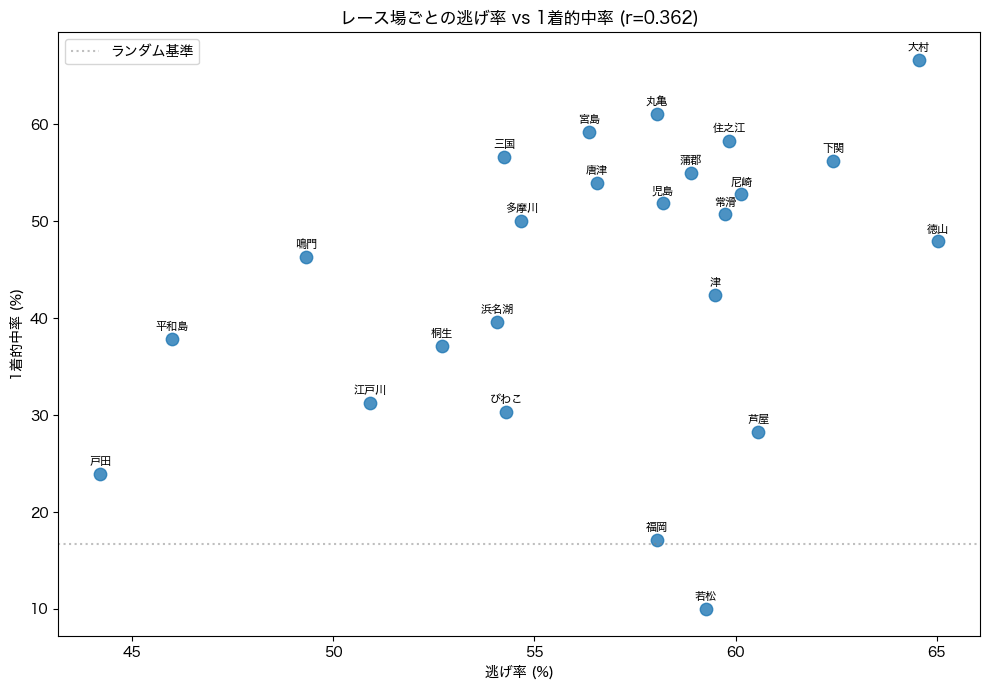

逃げ率と1着的中率の相関: r = 0.362


In [8]:
# 可視化: レース場ごとの逃げ率と1着予測精度の関係
# confirmデータを読み込み
confirm_dfs = []
for m in ['01', '02']:
    cdir = repo_root / 'data' / 'confirm' / '2026' / m
    if cdir.exists():
        for f in sorted(cdir.glob('*.csv')):
            try:
                confirm_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass

if confirm_dfs:
    confirm = pd.concat(confirm_dfs, ignore_index=True)
    confirm['場コード'] = confirm['レースコード'].str[8:10].astype(int)
    confirm['場名'] = confirm['場コード'].map(STADIUM_CODE_TO_NAME)
    confirm['hit1'] = confirm['1着的中'] == '○'

    stadium_acc = confirm.groupby('場名')['hit1'].mean() * 100

    # 逃げ率と精度の関連
    if '逃げ' in stadium_kimarite.columns:
        merged_stats = pd.DataFrame({
            '逃げ率': stadium_kimarite['逃げ'],
            '1着的中率': stadium_acc,
        }).dropna()

        fig, ax = plt.subplots(figsize=(10, 7))
        ax.scatter(merged_stats['逃げ率'], merged_stats['1着的中率'], s=80, alpha=0.8)
        for idx, row in merged_stats.iterrows():
            ax.annotate(idx, (row['逃げ率'], row['1着的中率']), fontsize=8,
                       ha='center', va='bottom', textcoords='offset points', xytext=(0, 5))

        r = merged_stats['逃げ率'].corr(merged_stats['1着的中率'])
        ax.set_xlabel('逃げ率 (%)')
        ax.set_ylabel('1着的中率 (%)')
        ax.set_title(f'レース場ごとの逃げ率 vs 1着的中率 (r={r:.3f})')
        ax.axhline(y=16.7, color='gray', linestyle=':', alpha=0.5, label='ランダム基準')
        ax.legend()
        plt.tight_layout()
        plt.show()

        print(f'逃げ率と1着的中率の相関: r = {r:.3f}')
else:
    print('confirmデータが見つかりません')

In [9]:
# 決まり手予測モデルの設計
print("""
=== 決まり手予測 中間モデルの設計 ===

【目的】
レースの決まり手（逃げ/差し/まくり）を予測し、
その予測結果を着順予測モデルの特徴量として追加する。

【入力特徴量（レース単位）】
1. レース場コード（場ごとの逃げ率が異なる）
2. 風速 × 風向（追い風は逃げ有利、向かい風はまくり有利）
3. 1号艇選手のA1級率・全国勝率（1号艇が強いほど逃げやすい）
4. 2-6号艇の最高全国勝率（攻め手が強いほど差し/まくり）
5. 1号艇のST平均（スタート巧拙）
6. 1号艇 vs 2号艇の全国勝率差
7. 級別分布（A1/A2/B1/B2の人数）

【出力】
3クラス分類: 逃げ / 差し / まくり
確率値として出力（P(逃げ), P(差し), P(まくり)）

【活用方法】
- P(逃げ) を着順予測モデルの特徴量として追加
  → P(逃げ)が高いレースで1号艇のスコアをブースト
- 各ボートに「決まり手確率 × コース一致度」を特徴量として付与
  例: 1号艇に P(逃げ) を追加、2-4号艇に P(差し) × 差し実績 を追加

【学習データ】
- 2016-2024年の results データ（決まり手列）
- NaN率 ~7.7%（不成立レース等）→ NaN行を除外して学習

【クラス不均衡対策】
逃げ 52.3% / 差し 25.2% / まくり 16.5% / NaN 6.0%
→ class_weight='balanced' または SMOTE

【評価基準】
- 逃げ予測の Precision/Recall が重要
  (逃げを正しく予測 → 1号艇=1着がほぼ確定)
- 最終評価は着順予測モデルの1着的中率向上で判断

【期待効果】
- 逃げレースの確信度が高いケースで1着精度向上 (+1-2%)
- 特に「逃げにくいレース場」での判別能力向上
""")


=== 決まり手予測 中間モデルの設計 ===

【目的】
レースの決まり手（逃げ/差し/まくり）を予測し、
その予測結果を着順予測モデルの特徴量として追加する。

【入力特徴量（レース単位）】
1. レース場コード（場ごとの逃げ率が異なる）
2. 風速 × 風向（追い風は逃げ有利、向かい風はまくり有利）
3. 1号艇選手のA1級率・全国勝率（1号艇が強いほど逃げやすい）
4. 2-6号艇の最高全国勝率（攻め手が強いほど差し/まくり）
5. 1号艇のST平均（スタート巧拙）
6. 1号艇 vs 2号艇の全国勝率差
7. 級別分布（A1/A2/B1/B2の人数）

【出力】
3クラス分類: 逃げ / 差し / まくり
確率値として出力（P(逃げ), P(差し), P(まくり)）

【活用方法】
- P(逃げ) を着順予測モデルの特徴量として追加
  → P(逃げ)が高いレースで1号艇のスコアをブースト
- 各ボートに「決まり手確率 × コース一致度」を特徴量として付与
  例: 1号艇に P(逃げ) を追加、2-4号艇に P(差し) × 差し実績 を追加

【学習データ】
- 2016-2024年の results データ（決まり手列）
- NaN率 ~7.7%（不成立レース等）→ NaN行を除外して学習

【クラス不均衡対策】
逃げ 52.3% / 差し 25.2% / まくり 16.5% / NaN 6.0%
→ class_weight='balanced' または SMOTE

【評価基準】
- 逃げ予測の Precision/Recall が重要
  (逃げを正しく予測 → 1号艇=1着がほぼ確定)
- 最終評価は着順予測モデルの1着的中率向上で判断

【期待効果】
- 逃げレースの確信度が高いケースで1着精度向上 (+1-2%)
- 特に「逃げにくいレース場」での判別能力向上



In [10]:
# 簡易的な決まり手予測モデルのプロトタイプ
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 特徴量の準備
# resultsにはレースレベルの情報のみ。programsとマージして選手情報を取得

# まずresultsのレースレベル特徴量で簡易検証
kimarite_data = results_all[results_all['決まり手'].isin(['逃げ', '差し', 'まくり'])].copy()
kimarite_data['場コード'] = kimarite_data['レースコード'].str[8:10].astype(int)
kimarite_data['風速_num'] = pd.to_numeric(kimarite_data['風速(m)'], errors='coerce').fillna(0)

# 風向をダミー変数化
wind_dir_unique = kimarite_data['風向'].dropna().unique()
print(f'風向の値: {sorted(wind_dir_unique)}')

# 風向をsin/cos変換（循環特徴量）
wind_direction_to_angle = {
    '北': 0, '北東': 45, '東': 90, '南東': 135,
    '南': 180, '南西': 225, '西': 270, '北西': 315,
}
kimarite_data['風向角度'] = kimarite_data['風向'].map(wind_direction_to_angle)
kimarite_data['風向sin'] = np.sin(np.radians(kimarite_data['風向角度']))
kimarite_data['風向cos'] = np.cos(np.radians(kimarite_data['風向角度']))

# 1着の艇番（逃げの指標として）
first_place_boat = reshape_results(kimarite_data)
first_place_boat = first_place_boat[first_place_boat['着順'] == 1][['レースコード', '艇番']].rename(
    columns={'艇番': '1着_艇番'}
)

feature_cols = ['場コード', '風速_num', '風向sin', '風向cos']
X = kimarite_data[feature_cols].copy()
y = kimarite_data['決まり手'].copy()

# NaN除去
valid_mask = X.notna().all(axis=1)
X = X[valid_mask]
y = y[valid_mask]

print(f'\n学習データ: {len(X)}レース')
print(f'クラス分布: {y.value_counts().to_dict()}')

風向の値: ['北', '北東', '北西', '南', '南東', '南西', '東', '西']



学習データ: 94830レース
クラス分布: {'逃げ': 53674, '差し': 25240, 'まくり': 15916}


In [11]:
# 時系列分割: 2024年データでtrain/test
kimarite_with_date = kimarite_data[valid_mask].copy()
kimarite_with_date['year'] = kimarite_with_date['レースコード'].str[:4].astype(int)

train_mask = kimarite_with_date['year'] == 2024
test_mask = kimarite_with_date['year'] == 2025

# 2024年前半 train, 後半 test（2025年は使わない）
kimarite_with_date['month'] = kimarite_with_date['レースコード'].str[4:6].astype(int)
train_mask = (kimarite_with_date['year'] == 2024) & (kimarite_with_date['month'] <= 9)
test_mask = (kimarite_with_date['year'] == 2024) & (kimarite_with_date['month'] >= 10)

X_train = X[train_mask.values]
y_train = y[train_mask.values]
X_test = X[test_mask.values]
y_test = y[test_mask.values]

print(f'Train: {len(X_train)} ({y_train.value_counts().to_dict()})')
print(f'Test:  {len(X_test)} ({y_test.value_counts().to_dict()})')

# ベースライン: 最頻クラス（逃げ）を常に予測
baseline_acc = (y_test == '逃げ').mean()
print(f'\nベースライン（常に逃げ）: {baseline_acc*100:.1f}%')

Train: 35968 ({'逃げ': 20323, '差し': 9763, 'まくり': 5882})
Test:  11364 ({'逃げ': 6492, '差し': 3015, 'まくり': 1857})

ベースライン（常に逃げ）: 57.1%


In [12]:
# GBCモデルで決まり手予測
gbc = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
acc = (y_pred == y_test).mean()

print(f'=== 決まり手予測結果（レースレベル特徴量のみ） ===')
print(f'精度: {acc*100:.1f}% (ベースライン: {baseline_acc*100:.1f}%)')
print()
print(classification_report(y_test, y_pred, target_names=['まくり', '差し', '逃げ'], zero_division=0))

# 特徴量重要度
print('\n=== 特徴量重要度 ===')
for name, imp in sorted(zip(feature_cols, gbc.feature_importances_), key=lambda x: -x[1]):
    print(f'  {name}: {imp:.4f}')

print(f'\n→ レースレベル特徴量のみでは限定的。')
print(f'  選手情報（1号艇の勝率、ST平均等）を追加すれば大幅改善の余地あり。')

=== 決まり手予測結果（レースレベル特徴量のみ） ===
精度: 57.0% (ベースライン: 57.1%)

              precision    recall  f1-score   support

         まくり       0.40      0.00      0.00      1857
          差し       0.35      0.02      0.04      3015
          逃げ       0.57      0.99      0.73      6492

    accuracy                           0.57     11364
   macro avg       0.44      0.34      0.25     11364
weighted avg       0.49      0.57      0.42     11364


=== 特徴量重要度 ===
  場コード: 0.5114
  風速_num: 0.2699
  風向cos: 0.1159
  風向sin: 0.1029

→ レースレベル特徴量のみでは限定的。
  選手情報（1号艇の勝率、ST平均等）を追加すれば大幅改善の余地あり。


---
## 2. 選手統計のスライディングウィンドウ化

### 背景
現在の `_player_stats` と `_stadium_player_stats` は学習時（2016-2024年）に
**全期間の平均値**として計算され、pkl に埋め込まれている。

問題点:
- 新人選手（2025年デビュー等）の統計がない
- 引退選手のデータが混ざる
- 選手の成長/衰退（年齢による変化）が反映されない
- 推論時に「最新データ」を使えない

In [13]:
# 現行の player_stats の分析
print('=== _player_stats の構成 ===')
print(f'Shape: {player_stats.shape}')
print(f'Columns: {list(player_stats.columns)}')
print(f'\nサンプル（先頭5件）:')
print(player_stats.head().to_string())
print(f'\n統計量:')
print(player_stats.describe().round(3).to_string())

=== _player_stats の構成 ===
Shape: (2064, 5)
Columns: ['登録番号', '履歴_平均着順', '履歴_1着率', '履歴_出走回数', 'イン1着率']

サンプル（先頭5件）:
   登録番号   履歴_平均着順    履歴_1着率  履歴_出走回数     イン1着率
0  2014  3.729024  0.105034     1609  0.290657
1  2380  3.912371  0.123711      194  0.387097
2  2504  4.181818  0.090909       11  0.333333
3  2505  4.029126  0.097087      103  0.384615
4  2528  3.448819  0.157480      127  0.434783

統計量:
           登録番号   履歴_平均着順    履歴_1着率   履歴_出走回数     イン1着率
count  2064.000  2064.000  2064.000  2064.000  1963.000
mean   4300.700     3.718     0.140  1089.830     0.462
std     672.092     0.602     0.073   587.982     0.165
min    2014.000     2.333     0.000     1.000     0.000
25%    3774.500     3.268     0.091   553.750     0.361
50%    4339.500     3.662     0.130  1222.000     0.473
75%    4874.250     3.997     0.190  1581.750     0.582
max    5391.000     6.000     0.396  2242.000     1.000


In [14]:
# stadium_player_stats の分析
print('=== _stadium_player_stats の構成 ===')
print(f'Shape: {stadium_player_stats.shape}')
print(f'Columns: {list(stadium_player_stats.columns)}')
print(f'\n選手あたりのレース場数:')
per_player = stadium_player_stats.groupby('登録番号').size()
print(f'  平均: {per_player.mean():.1f}場, 中央値: {per_player.median():.0f}場, '
      f'最大: {per_player.max()}場')
print(f'  1場のみ: {(per_player == 1).sum()}人 ({(per_player == 1).mean()*100:.1f}%)')
print(f'  全24場: {(per_player == 24).sum()}人')

=== _stadium_player_stats の構成 ===
Shape: (43754, 5)
Columns: ['登録番号', 'レース場', '当場_平均着順', '当場_1着率', '当場_出走回数']

選手あたりのレース場数:
  平均: 21.2場, 中央値: 23場, 最大: 24場
  1場のみ: 10人 (0.5%)
  全24場: 1003人


In [15]:
# 「データの古さ」の問題を検証
# 2025-2026年のprogramsに登場する選手のうち、player_statsに存在しない選手

prog_2026_dfs = []
for m in ['01', '02']:
    pdir = repo_root / 'data' / 'programs' / '2026' / m
    if pdir.exists():
        for f in sorted(pdir.glob('*.csv')):
            try:
                prog_2026_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass

prog_2026 = pd.concat(prog_2026_dfs, ignore_index=True)
prog_2026_long = reshape_programs(prog_2026)
prog_2026_long['登録番号'] = pd.to_numeric(prog_2026_long['登録番号'], errors='coerce')

active_players_2026 = set(prog_2026_long['登録番号'].dropna().unique())
stats_players = set(player_stats['登録番号'].unique())

missing_players = active_players_2026 - stats_players
obsolete_players = stats_players - active_players_2026

print(f'=== 選手統計の鮮度分析 ===')
print(f'2026年出走選手数: {len(active_players_2026)}')
print(f'player_stats 登録選手数: {len(stats_players)}')
print(f'\n統計なし選手（新人/復帰）: {len(missing_players)}人 '
      f'({len(missing_players)/len(active_players_2026)*100:.1f}%)')
print(f'出走なし選手（引退/休止）: {len(obsolete_players)}人 '
      f'({len(obsolete_players)/len(stats_players)*100:.1f}%)')

# 統計なし選手のレース数
missing_races = prog_2026_long[prog_2026_long['登録番号'].isin(missing_players)]
print(f'\n統計なし選手の出走回数: {len(missing_races)}回 '
      f'(全{len(prog_2026_long)}回中 {len(missing_races)/len(prog_2026_long)*100:.1f}%)')

=== 選手統計の鮮度分析 ===
2026年出走選手数: 1575
player_stats 登録選手数: 2064

統計なし選手（新人/復帰）: 52人 (3.3%)
出走なし選手（引退/休止）: 541人 (26.2%)

統計なし選手の出走回数: 861回 (全39108回中 2.2%)


In [16]:
# スライディングウィンドウの設計
print("""
=== スライディングウィンドウ型選手統計の設計 ===

【現状の問題】
1. player_stats は 2016-2024年の全期間平均 → 2025-2026年の新人が含まれない
2. 選手の成長/衰退が反映されない
3. pkl に埋め込まれているため、更新にはモデル再学習が必要

【設計案: 外部JSONファイル方式】

1. models/player_stats_latest.json として外部化:
   {
     "updated": "2026-02-08",
     "window_months": 12,
     "players": {
       "3900": {"平均着順": 3.21, "1着率": 0.18, "レース数": 142, ...},
       ...
     }
   }

2. 日次更新スクリプト (scripts/update_player_stats.py):
   - results データから直近12ヶ月の統計を再計算
   - daily-sync.yml の result.py 実行後に追加
   - pkl の静的統計はフォールバックとして残す

3. estimate.py の変更:
   - player_stats_latest.json を優先的に読み込み
   - 存在しない場合は pkl の _player_stats にフォールバック
   - 新人選手は json に最新統計が含まれる

【ウィンドウサイズの選択】
- 12ヶ月: 季節変動を含む完全な1サイクル（推奨）
- 6ヶ月: より最近の傾向を反映するが、データ不足の選手が増える
- 24ヶ月: 安定するが、変化への追従が遅い

【最小レース数の閾値】
- 直近12ヶ月で10走未満の選手は信頼性低
  → 全期間統計とブレンド（例: 重み = min(1, recent_races/30)）

【実装優先度】
Phase 4 の中では比較的実装しやすい改善。
特に新人選手の予測精度改善に直結する。
""")


=== スライディングウィンドウ型選手統計の設計 ===

【現状の問題】
1. player_stats は 2016-2024年の全期間平均 → 2025-2026年の新人が含まれない
2. 選手の成長/衰退が反映されない
3. pkl に埋め込まれているため、更新にはモデル再学習が必要

【設計案: 外部JSONファイル方式】

1. models/player_stats_latest.json として外部化:
   {
     "updated": "2026-02-08",
     "window_months": 12,
     "players": {
       "3900": {"平均着順": 3.21, "1着率": 0.18, "レース数": 142, ...},
       ...
     }
   }

2. 日次更新スクリプト (scripts/update_player_stats.py):
   - results データから直近12ヶ月の統計を再計算
   - daily-sync.yml の result.py 実行後に追加
   - pkl の静的統計はフォールバックとして残す

3. estimate.py の変更:
   - player_stats_latest.json を優先的に読み込み
   - 存在しない場合は pkl の _player_stats にフォールバック
   - 新人選手は json に最新統計が含まれる

【ウィンドウサイズの選択】
- 12ヶ月: 季節変動を含む完全な1サイクル（推奨）
- 6ヶ月: より最近の傾向を反映するが、データ不足の選手が増える
- 24ヶ月: 安定するが、変化への追従が遅い

【最小レース数の閾値】
- 直近12ヶ月で10走未満の選手は信頼性低
  → 全期間統計とブレンド（例: 重み = min(1, recent_races/30)）

【実装優先度】
Phase 4 の中では比較的実装しやすい改善。
特に新人選手の予測精度改善に直結する。



In [17]:
# スライディングウィンドウのプロトタイプ
# 2025年上半期の結果データから直近12ヶ月の統計を計算

results_for_sw = []
for year in ['2024', '2025']:
    for month in range(1, 13):
        res_dir = repo_root / 'data' / 'results' / year / f'{month:02d}'
        if not res_dir.exists():
            continue
        for f in sorted(res_dir.glob('*.csv')):
            try:
                results_for_sw.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass

all_results = pd.concat(results_for_sw, ignore_index=True)
all_results_long = reshape_results(all_results)
all_results_long['登録番号'] = pd.to_numeric(all_results_long['登録番号'], errors='coerce')
all_results_long['着順_num'] = pd.to_numeric(all_results_long['着順'], errors='coerce')
all_results_long['レース日_dt'] = pd.to_datetime(all_results_long['レース日'], errors='coerce')

def compute_sliding_stats(data, cutoff_date, window_months=12):
    """cutoff_date から遡って window_months 分の選手統計を計算"""
    start_date = cutoff_date - pd.DateOffset(months=window_months)
    window_data = data[(data['レース日_dt'] >= start_date) & (data['レース日_dt'] < cutoff_date)]
    
    stats = window_data.groupby('登録番号').agg(
        sw_平均着順=('着順_num', 'mean'),
        sw_1着率=('着順_num', lambda x: (x == 1).mean()),
        sw_3連対率=('着順_num', lambda x: (x <= 3).mean()),
        sw_レース数=('着順_num', 'count'),
    ).reset_index()
    return stats

# 2025年7月時点の12ヶ月ウィンドウ
sw_stats = compute_sliding_stats(all_results_long, pd.Timestamp('2025-07-01'), window_months=12)
print(f'スライディングウィンドウ統計（2024-07〜2025-06）:')
print(f'  選手数: {len(sw_stats)}')
print(f'  平均レース数: {sw_stats["sw_レース数"].mean():.1f}')
print(f'  10走未満: {(sw_stats["sw_レース数"] < 10).sum()}人 ({(sw_stats["sw_レース数"] < 10).mean()*100:.1f}%)')

# 全期間統計との比較
if player_stats is not None:
    compared = sw_stats.merge(player_stats, on='登録番号', suffixes=('_sw', '_all'))
    avg_col_all = [c for c in compared.columns if '平均着順' in c and '_all' in c or c == '平均着順']
    if avg_col_all:
        col = avg_col_all[0]
        diff = compared['sw_平均着順'] - compared[col]
        print(f'\n全期間平均着順 vs スライディングウィンドウ平均着順:')
        print(f'  平均差: {diff.mean():.4f} (正=最近の方が着順が悪い)')
        print(f'  差の標準偏差: {diff.std():.4f}')
        print(f'  |差|>0.5の選手: {(diff.abs() > 0.5).sum()}人 ({(diff.abs() > 0.5).mean()*100:.1f}%)')

スライディングウィンドウ統計（2024-07〜2025-06）:
  選手数: 1636
  平均レース数: 198.9
  10走未満: 5人 (0.3%)


---
## 3. 定期再学習パイプライン

### 背景
現在のモデルは2024年末までのデータで学習されているが、
再学習の仕組みがない。daily-sync.yml には推論パイプラインのみが定義されている。

問題点:
- lightgbm/optuna が requirements.txt に含まれていない
- 学習コードが notebook（program_v2.ipynb）にのみ存在
- CI/CDに再学習ステップがない
- モデルの劣化を自動検知できない

In [18]:
# 現行CI/CDパイプラインの分析
print("""
=== 現行 daily-sync.yml パイプライン ===

cron: "10 15 * * *" (UTC 15:10 = JST 00:10)

実行順序:
  1. result.py    → data/results/ に結果データ保存
  2. program.py   → data/programs/ に出走表保存  
  3. preview.py   → data/previews/ に直前情報保存
  4. prediction-preview.py → 合成Preview生成 (continue-on-error: true)
  5. estimate.py  → 予測実行
  6. confirm.py   → 的中確認
  
問題点:
  - 学習ステップがない
  - git commit/push ステップがない（手動?）
  - lightgbm/optuna は requirements.txt に未記載
  - 再学習にはGPU不要（LightGBMはCPUで十分）だが、
    GitHub Actions の無料枠（2,000分/月）の制約あり
""")


=== 現行 daily-sync.yml パイプライン ===

cron: "10 15 * * *" (UTC 15:10 = JST 00:10)

実行順序:
  1. result.py    → data/results/ に結果データ保存
  2. program.py   → data/programs/ に出走表保存  
  3. preview.py   → data/previews/ に直前情報保存
  4. prediction-preview.py → 合成Preview生成 (continue-on-error: true)
  5. estimate.py  → 予測実行
  6. confirm.py   → 的中確認

問題点:
  - 学習ステップがない
  - git commit/push ステップがない（手動?）
  - lightgbm/optuna は requirements.txt に未記載
  - 再学習にはGPU不要（LightGBMはCPUで十分）だが、
    GitHub Actions の無料枠（2,000分/月）の制約あり



In [19]:
# requirements.txt の分析
req_path = repo_root / 'scripts' / 'requirements.txt'
if req_path.exists():
    reqs = req_path.read_text().strip().split('\n')
    print('=== scripts/requirements.txt ===')
    for r in reqs:
        print(f'  {r}')
    
    # 学習に必要だが不足しているパッケージ
    required_for_training = ['lightgbm', 'optuna', 'scikit-learn']
    installed = [r.split('==')[0].split('>=')[0].lower() for r in reqs]
    print(f'\n=== 学習用パッケージの有無 ===')
    for pkg in required_for_training:
        status = '✓' if pkg in installed else '✗ 不足'
        print(f'  {pkg}: {status}')
else:
    print('requirements.txt が見つからない')

=== scripts/requirements.txt ===
  requests==2.31.0
  lhafile==0.3.1
  beautifulsoup4>=4.12.0
  lxml>=5.0.0
  numpy>=1.24.0
  pandas>=2.0.0
  scikit-learn==1.7.1
  pytest==7.4.3
  pytest-cov==4.1.0

=== 学習用パッケージの有無 ===
  lightgbm: ✗ 不足
  optuna: ✗ 不足
  scikit-learn: ✓


In [20]:
# 再学習パイプラインの設計
print("""
=== 定期再学習パイプライン設計 ===

【Phase A: 学習スクリプトの外部化】(前提作業)

1. program_v2.ipynb のコアロジックを scripts/train.py に抽出:
   - データ読み込み・前処理
   - Optuna ハイパーパラメータ最適化
   - 24レース場のモデル学習
   - player_stats / stadium_player_stats の計算
   - models/program_models_v2.pkl の保存

2. 設定のパラメータ化:
   - 学習期間（--train-start 2016 --train-end 2025）
   - Optunaの試行回数（--n-trials 30）
   - 出力パス（--output models/program_models_v2.pkl）

3. requirements-train.txt の作成:
   - lightgbm>=4.0
   - optuna>=3.0
   - scikit-learn>=1.3
   （推論用 requirements.txt とは分離）

【Phase B: CI/CDへの統合】

1. 月次再学習ワークフロー (retrain.yml):
   - schedule: cron: "0 0 1 * *" (毎月1日)
   - workflow_dispatch で手動起動も可能
   - ステップ:
     a. checkout + LFS pull
     b. pip install -r scripts/requirements-train.txt
     c. python scripts/train.py --train-end $(date -d 'last month' +%Y)
     d. python scripts/validate.py (新旧モデルの精度比較)
     e. 新モデルが旧モデルを上回る場合のみ:
        - git add models/program_models_v2.pkl
        - git commit + push
        - PR作成 (自動マージは避ける)

2. validate.py の設計:
   - 直近1ヶ月のデータで新旧モデルの精度を比較
   - 1着的中率が -2% 以上悪化しないことを確認
   - 三連単的中率が -1% 以上悪化しないことを確認
   - 結果をJSON出力（GitHub Actions artifact保存）

【Phase C: アラート連携】

1. confirm.py の強化:
   - 7日移動平均の1着的中率が40%未満 → Issue自動作成
   - 特定レース場で3日連続20%未満 → 再学習トリガー

2. Slack/Discord 通知（オプション）:
   - 日次精度レポート
   - 再学習完了通知

【GitHub Actions の制約】
- 無料枠: 2,000分/月
- 日次推論: ~5分/日 × 30日 = ~150分
- 月次再学習: ~30-60分（Optunaの試行回数に依存）
- 合計: ~200分/月 → 無料枠内に収まる
- LightGBM は CPU で十分高速（Optunaの30回でも10-20分程度）
""")


=== 定期再学習パイプライン設計 ===

【Phase A: 学習スクリプトの外部化】(前提作業)

1. program_v2.ipynb のコアロジックを scripts/train.py に抽出:
   - データ読み込み・前処理
   - Optuna ハイパーパラメータ最適化
   - 24レース場のモデル学習
   - player_stats / stadium_player_stats の計算
   - models/program_models_v2.pkl の保存

2. 設定のパラメータ化:
   - 学習期間（--train-start 2016 --train-end 2025）
   - Optunaの試行回数（--n-trials 30）
   - 出力パス（--output models/program_models_v2.pkl）

3. requirements-train.txt の作成:
   - lightgbm>=4.0
   - optuna>=3.0
   - scikit-learn>=1.3
   （推論用 requirements.txt とは分離）

【Phase B: CI/CDへの統合】

1. 月次再学習ワークフロー (retrain.yml):
   - schedule: cron: "0 0 1 * *" (毎月1日)
   - workflow_dispatch で手動起動も可能
   - ステップ:
     a. checkout + LFS pull
     b. pip install -r scripts/requirements-train.txt
     c. python scripts/train.py --train-end $(date -d 'last month' +%Y)
     d. python scripts/validate.py (新旧モデルの精度比較)
     e. 新モデルが旧モデルを上回る場合のみ:
        - git add models/program_models_v2.pkl
        - git commit + push
        - PR作成 (自動マージは避ける)

2. validate.py の設計:

In [21]:
# 学習時間の推定（現行notebook相当の処理）
# 実際の学習は行わず、データサイズから推定

# 学習データ規模の推定
total_programs = 0
for year_dir in (repo_root / 'data' / 'programs').iterdir():
    if year_dir.is_dir():
        for month_dir in year_dir.iterdir():
            if month_dir.is_dir():
                total_programs += len(list(month_dir.glob('*.csv')))

total_results = 0
for year_dir in (repo_root / 'data' / 'results').iterdir():
    if year_dir.is_dir():
        for month_dir in year_dir.iterdir():
            if month_dir.is_dir():
                total_results += len(list(month_dir.glob('*.csv')))

print(f'=== 学習データ規模 ===')
print(f'Programs CSV数: {total_programs}日分')
print(f'Results CSV数: {total_results}日分')
print(f'\n推定レース数: ~{total_results * 144:,} (1日あたり約144レース × 24場 × 12R / 2)')
print(f'推定データ行数: ~{total_results * 144 * 6:,} (6艇/レース)')
print(f'\n学習所要時間の推定:')
print(f'  データ読み込み: ~2-5分')
print(f'  特徴量生成: ~3-5分')
print(f'  Optuna (30回): ~10-20分')
print(f'  24場のモデル学習: ~5-10分')
print(f'  合計: ~20-40分 (GitHub Actions runner)')

=== 学習データ規模 ===
Programs CSV数: 3689日分
Results CSV数: 3688日分

推定レース数: ~531,072 (1日あたり約144レース × 24場 × 12R / 2)
推定データ行数: ~3,186,432 (6艇/レース)

学習所要時間の推定:
  データ読み込み: ~2-5分
  特徴量生成: ~3-5分
  Optuna (30回): ~10-20分
  24場のモデル学習: ~5-10分
  合計: ~20-40分 (GitHub Actions runner)


---
## 4. モデルバージョン管理の体系化

### 背景
現在のpklファイルにはモデル本体のみが保存されており、
学習日時・データ範囲・精度メトリクス・ハイパーパラメータなどの
メタデータが一切含まれていない。

A/Bテストやロールバックが不可能。

In [22]:
# 現行モデルファイルの分析
model_files = list((repo_root / 'models').glob('*.pkl'))
print('=== models/ ディレクトリの内容 ===')
for f in sorted(model_files):
    size_mb = f.stat().st_size / (1024 * 1024)
    mtime = pd.Timestamp.fromtimestamp(f.stat().st_mtime)
    print(f'  {f.name}: {size_mb:.1f} MB (更新日: {mtime.strftime("%Y-%m-%d %H:%M")})')

# .gitattributes の確認
gitattr_path = repo_root / 'models' / '.gitattributes'
if gitattr_path.exists():
    print(f'\n=== models/.gitattributes ===')
    print(f'  {gitattr_path.read_text().strip()}')

# pklの中身のキーを確認
print(f'\n=== program_models_v2.pkl のキー ===')
for key in sorted(models.keys(), key=str):
    val = models[key]
    if isinstance(val, dict):
        print(f'  {key}: dict with keys {list(val.keys())}')
    elif isinstance(val, pd.DataFrame):
        print(f'  {key}: DataFrame {val.shape}')
    elif isinstance(val, tuple):
        print(f'  {key}: tuple {val}')
    else:
        print(f'  {key}: {type(val).__name__}')

print(f'\n→ メタデータキー（_training_date, _data_range, _metrics等）: なし')

=== models/ ディレクトリの内容 ===
  preview_models.pkl: 290.8 MB (更新日: 2026-02-03 09:49)
  program_models.pkl: 18.0 MB (更新日: 2026-02-03 09:49)
  program_models_v2.pkl: 30.7 MB (更新日: 2026-02-07 08:37)
  stadium_models.pkl: 15.1 MB (更新日: 2026-02-03 09:49)

=== models/.gitattributes ===
  *.pkl filter=lfs diff=lfs merge=lfs -text

=== program_models_v2.pkl のキー ===
  1: dict with keys ['features', 'model', 'scaler', 'ranking_model', 'classifier_model', 'classifier_scaler']
  10: dict with keys ['features', 'model', 'scaler', 'ranking_model', 'classifier_model', 'classifier_scaler']
  11: dict with keys ['features', 'model', 'scaler', 'ranking_model', 'classifier_model', 'classifier_scaler']
  12: dict with keys ['features', 'model', 'scaler', 'ranking_model', 'classifier_model', 'classifier_scaler']
  13: dict with keys ['features', 'model', 'scaler', 'ranking_model', 'classifier_model', 'classifier_scaler']
  14: dict with keys ['features', 'model', 'scaler', 'ranking_model', 'classifier_model', 

In [23]:
# モデルバージョン管理の設計
print("""
=== モデルバージョン管理の設計 ===

【方針: pkl内メタデータ + 外部マニフェスト】

1. pkl 内にメタデータキーを追加:
   models_dict['_metadata'] = {
       'version': 'v2.1.0',
       'training_date': '2026-02-01T00:00:00',
       'data_range': {'start': '2016-01-01', 'end': '2025-12-31'},
       'n_races_train': 250000,
       'metrics': {
           'val_1st_accuracy': 0.550,
           'val_trifecta_accuracy': 0.081,
           'val_ndcg3': 0.7429,
       },
       'hyperparams': {
           'num_leaves': 60,
           'learning_rate': 0.01102,
           'n_optuna_trials': 30,
       },
       'ensemble_config': {
           'weights': (0.7, 0.2, 0.1),
           'models': ['LambdaRank', 'LGBMClassifier', 'GBC(not_saved)'],
       },
       'feature_count': 33,
       'stadiums': 24,
       'git_commit': 'abc1234',
   }

2. 外部マニフェスト (models/manifest.json):
   {
     "current": "program_models_v2.pkl",
     "history": [
       {
         "file": "program_models_v2.pkl",
         "version": "v2.1.0",
         "training_date": "2026-02-01",
         "metrics": {"val_1st_accuracy": 0.550, ...},
         "deployed_at": "2026-02-01T12:00:00",
         "status": "active"
       },
       {
         "file": "program_models_v2_20260101.pkl",
         "version": "v2.0.0",
         ...
         "status": "archived"
       }
     ]
   }

3. estimate.py の変更:
   - manifest.json から "current" のモデルファイル名を取得
   - ロールバック: manifest.json の "current" を旧バージョンに変更するだけ
   - メタデータを予測結果のヘッダーに出力（トレーサビリティ）

4. Git LFS戦略:
   - 現状: models/*.pkl が LFS 管理
   - 履歴モデルは models/archive/ に移動
   - 直近2世代のみ保持（それ以前はGit LFS historyに残る）

【ロールバック手順】
# 問題検知時:
1. confirm.py でアラート発生
2. models/manifest.json の "current" を前バージョンに変更
3. git commit + push
4. 次回 daily-sync から旧モデルで推論

【A/Bテスト】
1. estimate.py に --model-version オプション追加
2. 2つのバージョンで同一日の予測を生成
3. confirm.py で両方の精度を比較
4. 勝者を "current" に設定
""")


=== モデルバージョン管理の設計 ===

【方針: pkl内メタデータ + 外部マニフェスト】

1. pkl 内にメタデータキーを追加:
   models_dict['_metadata'] = {
       'version': 'v2.1.0',
       'training_date': '2026-02-01T00:00:00',
       'data_range': {'start': '2016-01-01', 'end': '2025-12-31'},
       'n_races_train': 250000,
       'metrics': {
           'val_1st_accuracy': 0.550,
           'val_trifecta_accuracy': 0.081,
           'val_ndcg3': 0.7429,
       },
       'hyperparams': {
           'num_leaves': 60,
           'learning_rate': 0.01102,
           'n_optuna_trials': 30,
       },
       'ensemble_config': {
           'weights': (0.7, 0.2, 0.1),
           'models': ['LambdaRank', 'LGBMClassifier', 'GBC(not_saved)'],
       },
       'feature_count': 33,
       'stadiums': 24,
       'git_commit': 'abc1234',
   }

2. 外部マニフェスト (models/manifest.json):
   {
     "current": "program_models_v2.pkl",
     "history": [
       {
         "file": "program_models_v2.pkl",
         "version": "v2.1.0",
         "training_date"

In [24]:
# メタデータ付きモデル保存のプロトタイプ
import json
from datetime import datetime

def save_model_with_metadata(
    models_dict: dict,
    output_path: Path,
    manifest_path: Path,
    version: str,
    data_range: dict,
    metrics: dict,
    hyperparams: dict,
):
    """メタデータ付きでモデルを保存し、マニフェストを更新する"""
    metadata = {
        'version': version,
        'training_date': datetime.now().isoformat(),
        'data_range': data_range,
        'metrics': metrics,
        'hyperparams': hyperparams,
        'feature_count': len(models_dict.get(1, {}).get('features', [])),
        'stadiums': len([k for k in models_dict if isinstance(k, int)]),
    }
    
    models_dict['_metadata'] = metadata
    
    # pkl 保存 (実際にはここでは保存しない)
    # with open(output_path, 'wb') as f:
    #     pickle.dump(models_dict, f)
    
    # マニフェスト更新
    if manifest_path.exists():
        manifest = json.loads(manifest_path.read_text())
    else:
        manifest = {'current': None, 'history': []}
    
    entry = {
        'file': output_path.name,
        'version': version,
        'training_date': metadata['training_date'],
        'metrics': metrics,
        'deployed_at': datetime.now().isoformat(),
        'status': 'active',
    }
    
    # 旧バージョンをarchived に
    for h in manifest['history']:
        if h['status'] == 'active':
            h['status'] = 'archived'
    
    manifest['current'] = output_path.name
    manifest['history'].insert(0, entry)
    
    return manifest

# デモ
demo_manifest = save_model_with_metadata(
    models_dict=dict(models),  # copy
    output_path=Path('models/program_models_v2.pkl'),
    manifest_path=Path('models/manifest.json'),
    version='v2.0.0',
    data_range={'start': '2016-01-01', 'end': '2024-12-31'},
    metrics={'val_1st_accuracy': 0.550, 'val_trifecta': 0.081, 'val_ndcg3': 0.7429},
    hyperparams={'num_leaves': 60, 'learning_rate': 0.01102},
)

print('=== マニフェスト デモ出力 ===')
print(json.dumps(demo_manifest, indent=2, default=str))

=== マニフェスト デモ出力 ===
{
  "current": "program_models_v2.pkl",
  "history": [
    {
      "file": "program_models_v2.pkl",
      "version": "v2.0.0",
      "training_date": "2026-02-10T10:24:44.057319",
      "metrics": {
        "val_1st_accuracy": 0.55,
        "val_trifecta": 0.081,
        "val_ndcg3": 0.7429
      },
      "deployed_at": "2026-02-10T10:24:44.057454",
      "status": "active"
    }
  ]
}


---
## 5. データストレージのParquet移行

### 背景
全データがCSV形式で保存されており、
読み込み速度とストレージ効率に課題がある。

特に学習時には数年分のデータを一括読み込みする必要があり、
I/Oがボトルネックになる可能性がある。

In [25]:
# データストレージの現状分析
data_dirs = {
    'programs': repo_root / 'data' / 'programs',
    'results': repo_root / 'data' / 'results',
    'previews': repo_root / 'data' / 'previews',
    'estimates': repo_root / 'data' / 'estimates',
    'confirm': repo_root / 'data' / 'confirm',
    'prediction-preview': repo_root / 'data' / 'prediction-preview',
}

print('=== データストレージ分析 ===')
total_size = 0
total_files = 0

for name, path in data_dirs.items():
    if not path.exists():
        print(f'  {name}: ディレクトリなし')
        continue
    csv_files = list(path.rglob('*.csv'))
    size_mb = sum(f.stat().st_size for f in csv_files) / (1024 * 1024)
    total_size += size_mb
    total_files += len(csv_files)
    print(f'  {name}: {len(csv_files)}ファイル, {size_mb:.1f} MB')

print(f'\n合計: {total_files}ファイル, {total_size:.1f} MB')

=== データストレージ分析 ===
  programs: 3689ファイル, 382.5 MB


  results: 3688ファイル, 271.2 MB


  previews: 3688ファイル, 141.8 MB
  estimates: ディレクトリなし
  confirm: 20ファイル, 0.1 MB
  prediction-preview: 9ファイル, 0.6 MB

合計: 11094ファイル, 796.1 MB


In [26]:
# CSV vs Parquet の読み込み速度比較
# 実際のデータでベンチマーク

# programs の1ヶ月分で比較
test_dir = repo_root / 'data' / 'programs' / '2025' / '06'
if not test_dir.exists():
    # 存在するディレクトリを探す
    for year in ['2025', '2024']:
        for month in range(12, 0, -1):
            test_dir = repo_root / 'data' / 'programs' / year / f'{month:02d}'
            if test_dir.exists() and len(list(test_dir.glob('*.csv'))) > 0:
                break
        else:
            continue
        break

csv_files = sorted(test_dir.glob('*.csv'))
print(f'テストディレクトリ: {test_dir}')
print(f'CSVファイル数: {len(csv_files)}')

# CSV 読み込みベンチマーク
start = time.time()
dfs_csv = []
for f in csv_files:
    try:
        dfs_csv.append(pd.read_csv(f, dtype={'レースコード': str}))
    except Exception:
        pass
csv_time = time.time() - start
csv_df = pd.concat(dfs_csv, ignore_index=True)

# Parquet に変換して読み込みベンチマーク
import tempfile
with tempfile.NamedTemporaryFile(suffix='.parquet', delete=False) as tmp:
    parquet_path = tmp.name

# mixed type のカラムを文字列に統一（object型カラムの数値・文字列混在を解消）
for col in csv_df.select_dtypes(include=["object"]).columns:
    csv_df[col] = csv_df[col].astype(str)
csv_df.to_parquet(parquet_path, index=False)

csv_size = sum(f.stat().st_size for f in csv_files)
parquet_size = os.path.getsize(parquet_path)

start = time.time()
df_parquet = pd.read_parquet(parquet_path)
parquet_time = time.time() - start

os.unlink(parquet_path)

print(f'\n=== CSV vs Parquet ベンチマーク ({len(csv_files)}日分) ===')
print(f'行数: {len(csv_df)}')
print(f'\nCSV:')
print(f'  サイズ: {csv_size/1024:.1f} KB')
print(f'  読み込み時間: {csv_time*1000:.1f} ms')
print(f'\nParquet:')
print(f'  サイズ: {parquet_size/1024:.1f} KB')
print(f'  読み込み時間: {parquet_time*1000:.1f} ms')
print(f'\n圧縮率: {parquet_size/csv_size*100:.1f}% (Parquet/CSV)')
print(f'速度向上: {csv_time/parquet_time:.1f}x')

テストディレクトリ: /Users/mahiguch/dev/boatrace/data/data/programs/2025/06
CSVファイル数: 30



=== CSV vs Parquet ベンチマーク (30日分) ===
行数: 4731

CSV:
  サイズ: 3350.9 KB
  読み込み時間: 456.1 ms

Parquet:
  サイズ: 974.2 KB
  読み込み時間: 210.2 ms

圧縮率: 29.1% (Parquet/CSV)
速度向上: 2.2x


In [27]:
# 全データでの推定
print(f"""
=== Parquet移行の推定効果 ===

【サイズ削減】
現在のCSV合計: {total_size:.0f} MB
Parquet推定(30-50%圧縮): {total_size*0.3:.0f}-{total_size*0.5:.0f} MB
削減量: {total_size*0.5:.0f}-{total_size*0.7:.0f} MB

【読み込み速度】
日次推論（1日分CSVのみ）: 影響小（数十ms → 数ms）
学習（数年分一括読み込み）: 大きな効果
  - CSV: 数十秒 → Parquet: 数秒
  - 特に programs（177列）の読み込みが高速化

【移行戦略】

案A: 段階的移行（推奨）
  1. 新規データは CSV + Parquet の両方で保存
  2. 学習スクリプトは Parquet を優先読み込み
  3. 推論スクリプトは CSV のまま（1日分のみなので影響小）
  4. 過去データは一括変換スクリプトで Parquet 化

案B: 一括移行
  - 全CSVをParquetに変換
  - 全スクリプトを一度に修正
  - リスク: 互換性問題が一度に発生

案C: 月次集約Parquet
  - 日次CSVはそのまま
  - 月単位で集約したParquetを生成（data/parquet/programs/2025-06.parquet）
  - 学習時は月次Parquetを使用
  - 最も安全な移行パス

【推奨: 案C → 案A】
まず案Cで学習パイプラインの高速化を実現し、
安定したら案Aに移行する。
日次推論はCSVのままで問題ない（パフォーマンスへの影響が軽微なため）。
""")


=== Parquet移行の推定効果 ===

【サイズ削減】
現在のCSV合計: 796 MB
Parquet推定(30-50%圧縮): 239-398 MB
削減量: 398-557 MB

【読み込み速度】
日次推論（1日分CSVのみ）: 影響小（数十ms → 数ms）
学習（数年分一括読み込み）: 大きな効果
  - CSV: 数十秒 → Parquet: 数秒
  - 特に programs（177列）の読み込みが高速化

【移行戦略】

案A: 段階的移行（推奨）
  1. 新規データは CSV + Parquet の両方で保存
  2. 学習スクリプトは Parquet を優先読み込み
  3. 推論スクリプトは CSV のまま（1日分のみなので影響小）
  4. 過去データは一括変換スクリプトで Parquet 化

案B: 一括移行
  - 全CSVをParquetに変換
  - 全スクリプトを一度に修正
  - リスク: 互換性問題が一度に発生

案C: 月次集約Parquet
  - 日次CSVはそのまま
  - 月単位で集約したParquetを生成（data/parquet/programs/2025-06.parquet）
  - 学習時は月次Parquetを使用
  - 最も安全な移行パス

【推奨: 案C → 案A】
まず案Cで学習パイプラインの高速化を実現し、
安定したら案Aに移行する。
日次推論はCSVのままで問題ない（パフォーマンスへの影響が軽微なため）。



---
## 6. 風向エンコーディング改善

### 背景
風向データのエンコーディングに深刻な不整合がある:

- **results** (parser.py): 8方位テキスト（北, 北東, 東, 南東, 南, 南西, 西, 北西）
- **previews** (preview_scraper.py): HTMLのCSSクラス（is-wind1〜is-wind5）を4段階コードに変換
- **prediction-preview** (prediction-preview.py): デフォルト値 `1`（北）で固定

問題:
1. 8方位 → 4コードのマッピングで情報損失
2. `_parse_wind_direction()` で「北東」→1（北と同じ）になるバグ
3. `_extract_wind_code_from_class()` で is-wind6〜is-wind8 が未対応
4. 学習データ（results）と推論データ（previews）で風向の粒度が異なる

In [28]:
# 風向データの現状分析

# results の風向分布
print('=== results の風向分布 (2024-2025) ===')
wind_dist = results_all['風向'].value_counts(dropna=False)
for k, v in wind_dist.items():
    pct = v / len(results_all) * 100
    print(f'  {k}: {v} ({pct:.1f}%)')

print(f'\nユニーク値: {sorted(results_all["風向"].dropna().unique())}')

=== results の風向分布 (2024-2025) ===
  北西: 17135 (15.6%)
  南: 14485 (13.2%)
  北: 14189 (12.9%)
  南東: 12786 (11.7%)
  南西: 12153 (11.1%)
  北東: 11041 (10.1%)
  東: 10953 (10.0%)
  西: 9916 (9.0%)
  nan: 6981 (6.4%)

ユニーク値: ['北', '北東', '北西', '南', '南東', '南西', '東', '西']


In [29]:
# preview_scraper.py の風向エンコーディング問題の分析
print("""
=== preview_scraper.py の風向エンコーディング ===

【_parse_wind_direction() の問題】
direction_map = {
    "北": 1,
    "東": 2,
    "南": 3,
    "西": 4,
}

処理: `if key in wind_text: return code`

問題: 部分一致のため:
  - "北東" → "北" が先にマッチ → 1（北）を返す  ✗
  - "南東" → "南" が先にマッチ → 3（南）を返す  ✗
  - "北西" → "北" が先にマッチ → 1（北）を返す  ✗
  - "南西" → "南" が先にマッチ → 3（南）を返す  ✗

→ 8方位が事実上4方位に圧縮されるが、圧縮ロジックが不正確

【_extract_wind_code_from_class() の問題】
wind_map = {
    "is-wind1": 1,  # 北
    "is-wind2": 2,  # 北東
    "is-wind3": 2,  # 東    ← 北東と東が同じコード
    "is-wind4": 3,  # 南東
    "is-wind5": 4,  # 南
}

問題:
  1. is-wind6（南西）, is-wind7（西）, is-wind8（北西）が未定義
     → None を返す → NaN になる
  2. HTMLの実際のクラスがis-wind1〜16の場合（16方位コンパス）、
     未対応のコードが多数発生する可能性
  3. ドキュメンテーション上 is-wind1=北 だが、実際のHTML上では
     異なる方位を示している可能性
""")


=== preview_scraper.py の風向エンコーディング ===

【_parse_wind_direction() の問題】
direction_map = {
    "北": 1,
    "東": 2,
    "南": 3,
    "西": 4,
}

処理: `if key in wind_text: return code`

問題: 部分一致のため:
  - "北東" → "北" が先にマッチ → 1（北）を返す  ✗
  - "南東" → "南" が先にマッチ → 3（南）を返す  ✗
  - "北西" → "北" が先にマッチ → 1（北）を返す  ✗
  - "南西" → "南" が先にマッチ → 3（南）を返す  ✗

→ 8方位が事実上4方位に圧縮されるが、圧縮ロジックが不正確

【_extract_wind_code_from_class() の問題】
wind_map = {
    "is-wind1": 1,  # 北
    "is-wind2": 2,  # 北東
    "is-wind3": 2,  # 東    ← 北東と東が同じコード
    "is-wind4": 3,  # 南東
    "is-wind5": 4,  # 南
}

問題:
  1. is-wind6（南西）, is-wind7（西）, is-wind8（北西）が未定義
     → None を返す → NaN になる
  2. HTMLの実際のクラスがis-wind1〜16の場合（16方位コンパス）、
     未対応のコードが多数発生する可能性
  3. ドキュメンテーション上 is-wind1=北 だが、実際のHTML上では
     異なる方位を示している可能性



In [30]:
# previews の風向分布を確認
preview_dfs = []
for m in ['01', '02', '03']:
    pdir = repo_root / 'data' / 'previews' / '2025' / m
    if pdir.exists():
        for f in sorted(pdir.glob('*.csv')):
            try:
                preview_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass

if preview_dfs:
    previews = pd.concat(preview_dfs, ignore_index=True)
    print('=== previews の風向分布 ===')
    wind_preview = previews['風向'].value_counts(dropna=False).sort_index()
    for k, v in wind_preview.items():
        pct = v / len(previews) * 100
        print(f'  {k}: {v} ({pct:.1f}%)')
    
    print(f'\nNaN率: {previews["風向"].isna().mean()*100:.1f}%')
    print(f'\n→ 風向が数値コード（1-4?）で保存されていることを確認')
else:
    print('previews データなし')

=== previews の風向分布 ===
  1.0: 7325 (51.9%)
  2.0: 1874 (13.3%)
  3.0: 897 (6.4%)
  4.0: 1440 (10.2%)
  nan: 2569 (18.2%)

NaN率: 18.2%

→ 風向が数値コード（1-4?）で保存されていることを確認


In [31]:
# 風向の改善設計
print("""
=== 風向エンコーディングの改善設計 ===

【根本問題】
results: テキスト8方位（北, 北東, 東, ...）
previews: 数値コード（1-4 or 1-16）
prediction-preview: 固定値1
→ 3つのデータソースで風向の表現が異なる

【改善案1: 統一的な角度エンコーディング（推奨）】

全データソースを角度（0-360度）に変換し、sin/cosで特徴量化:

# results (parser.py の出力)
WIND_DIR_TO_ANGLE = {
    '北': 0, '北東': 45, '東': 90, '南東': 135,
    '南': 180, '南西': 225, '西': 270, '北西': 315,
}

# previews (scraper の is-windN を角度に)
# 実際のHTMLを確認して正確なマッピングを作成する必要あり
WIND_CLASS_TO_ANGLE = {
    'is-wind1': 0,    # 北
    'is-wind2': 45,   # 北東
    'is-wind3': 90,   # 東
    'is-wind4': 135,  # 南東
    'is-wind5': 180,  # 南
    'is-wind6': 225,  # 南西
    'is-wind7': 270,  # 西
    'is-wind8': 315,  # 北西
    # is-wind9〜16 があるなら16方位
}

# 特徴量:
wind_rad = np.radians(angle)
wind_sin = np.sin(wind_rad)  # 東(+) / 西(-) 成分
wind_cos = np.cos(wind_rad)  # 北(+) / 南(-) 成分

メリット:
- 循環性を正しく表現（北=0度 と 北西=315度が近い）
- 風速との組み合わせが自然（ベクトル化可能）
- 8方位でも16方位でも同じ特徴空間

【改善案2: 追い風/向かい風の2値化】

ボートレースでは風向が着順に影響する主なメカニズム:
- 追い風（南: ホームストレッチ側）→ 助走距離が短く感じる → インが不利になりやすい
- 向かい風（北: バックストレッチ側）→ スタートが慎重になる → インが有利

→ 実質的に 追い風/横風/向かい風 の3値で十分かもしれない

注意: 競艇場のレイアウトにより「追い風」の方角が異なる場合がある
→ 場ごとの補正が必要（大多数はホームストレッチが南向き）

【改善案3: weather_stats.json の活用】

既に scripts/build_weather_stats.py が存在し、
レース場×月の天候統計を models/weather_stats.json に出力。
→ 「当日の風向が当場月の平均からどれだけ外れているか」を特徴量化

【修正すべきバグ】
1. _parse_wind_direction(): 8方位マップに修正（辞書の順序を2文字→1文字に）
2. _extract_wind_code_from_class(): is-wind6〜8 を追加
3. prediction-preview.py: weather_stats.json からの確率的サンプリングに変更
4. estimate.py / program_v2.ipynb: 風向をsin/cos特徴量化
""")


=== 風向エンコーディングの改善設計 ===

【根本問題】
results: テキスト8方位（北, 北東, 東, ...）
previews: 数値コード（1-4 or 1-16）
prediction-preview: 固定値1
→ 3つのデータソースで風向の表現が異なる

【改善案1: 統一的な角度エンコーディング（推奨）】

全データソースを角度（0-360度）に変換し、sin/cosで特徴量化:

# results (parser.py の出力)
WIND_DIR_TO_ANGLE = {
    '北': 0, '北東': 45, '東': 90, '南東': 135,
    '南': 180, '南西': 225, '西': 270, '北西': 315,
}

# previews (scraper の is-windN を角度に)
# 実際のHTMLを確認して正確なマッピングを作成する必要あり
WIND_CLASS_TO_ANGLE = {
    'is-wind1': 0,    # 北
    'is-wind2': 45,   # 北東
    'is-wind3': 90,   # 東
    'is-wind4': 135,  # 南東
    'is-wind5': 180,  # 南
    'is-wind6': 225,  # 南西
    'is-wind7': 270,  # 西
    'is-wind8': 315,  # 北西
    # is-wind9〜16 があるなら16方位
}

# 特徴量:
wind_rad = np.radians(angle)
wind_sin = np.sin(wind_rad)  # 東(+) / 西(-) 成分
wind_cos = np.cos(wind_rad)  # 北(+) / 南(-) 成分

メリット:
- 循環性を正しく表現（北=0度 と 北西=315度が近い）
- 風速との組み合わせが自然（ベクトル化可能）
- 8方位でも16方位でも同じ特徴空間

【改善案2: 追い風/向かい風の2値化】

ボートレースでは風向が着順に影響する主なメカニズム:
- 追い風（南: ホームストレッチ側）→ 助走距離が短く感じる → インが不利になりやすい
- 向かい風（北: バ

In [32]:
# 風向の着順への影響を定量化
# ボートレースでは一般に追い風（南寄り）がインに不利

first_place_with_wind = results_all.copy()
first_place_with_wind['風向_角度'] = first_place_with_wind['風向'].map({
    '北': 0, '北東': 45, '東': 90, '南東': 135,
    '南': 180, '南西': 225, '西': 270, '北西': 315,
})

# 1着が1号艇（インコース勝利）かどうか
fp = reshape_results(first_place_with_wind)
fp_1st = fp[fp['着順'] == 1].copy()
fp_1st['1号艇勝利'] = (fp_1st['艇番'].astype(float) == 1).astype(int)

# 風向別の1号艇勝利率
wind_in_rate = fp_1st.groupby('風向')['1号艇勝利'].agg(['mean', 'count'])
wind_in_rate.columns = ['1号艇勝率', 'レース数']
wind_in_rate['1号艇勝率'] = (wind_in_rate['1号艇勝率'] * 100).round(1)

# 風向の順序を方角順に
wind_order = ['北', '北東', '東', '南東', '南', '南西', '西', '北西']
wind_in_rate = wind_in_rate.reindex([w for w in wind_order if w in wind_in_rate.index])

print('=== 風向別 1号艇（イン）勝率 ===')
print(wind_in_rate.to_string())
print(f'\n全体平均: {fp_1st["1号艇勝利"].mean()*100:.1f}%')

if len(wind_in_rate) > 1:
    diff = wind_in_rate['1号艇勝率'].max() - wind_in_rate['1号艇勝率'].min()
    print(f'最大-最小: {diff:.1f}ポイント')
    print(f'→ 風向が1号艇勝率に{"有意な" if diff > 5 else "軽微な"}影響')

=== 風向別 1号艇（イン）勝率 ===
    1号艇勝率   レース数
風向              
北    55.4  14189
北東   54.4  11041
東    53.2  10953
南東   54.3  12786
南    53.5  14485
南西   55.8  12153
西    54.7   9916
北西   53.5  17135

全体平均: 54.4%
最大-最小: 2.6ポイント
→ 風向が1号艇勝率に軽微な影響


In [33]:
# 風速×風向の交互作用
# 強風＋追い風 → イン不利度が増幅されるか

fp_1st['風速_num'] = pd.to_numeric(fp_1st['風速(m)'], errors='coerce')
fp_1st['追い風'] = fp_1st['風向'].isin(['南', '南東', '南西']).astype(int)
fp_1st['向かい風'] = fp_1st['風向'].isin(['北', '北東', '北西']).astype(int)

# 風速区間×追い風/向かい風
fp_1st['風速区間'] = pd.cut(fp_1st['風速_num'], bins=[0, 2, 4, 20], labels=['弱風(0-2m)', '中風(3-4m)', '強風(5m+)'])

cross_table = pd.crosstab(
    fp_1st['風速区間'],
    fp_1st['追い風'].map({0: '追い風以外', 1: '追い風'}),
    values=fp_1st['1号艇勝利'],
    aggfunc='mean'
) * 100

print('=== 風速×追い風: 1号艇勝率 (%) ===')
print(cross_table.round(1).to_string())

print(f'\n→ 強風×追い風でイン勝率が下がるなら、交互作用特徴量の根拠になる')

=== 風速×追い風: 1号艇勝率 (%) ===
追い風        追い風  追い風以外
風速区間                 
弱風(0-2m)  57.2   57.1
中風(3-4m)  53.9   52.6
強風(5m+)   48.6   50.3

→ 強風×追い風でイン勝率が下がるなら、交互作用特徴量の根拠になる


---
## 7. まとめと実装優先順位

### Phase 1-3 の完了状況

Phase 1-3 の実装が完了し、以下の改善が反映済みである。

#### Phase 1 完了項目

| 項目 | 内容 | 効果 |
|------|------|------|
| P0-1 コースデータ修正 | `estimate.py` が実績 previews を優先読み込み | コース特徴量の正常化 |
| P0-2 体重(kg) NaN修正 | programs の体重データで補完 | 全場NaN率100%を解消 |
| P1-3 イン有利度データ駆動化 | 24場別の1着率ベースマップに置換 | 場の特性を反映 |
| P1-4 日次数の追加 | `exclude_cols` から除外し再学習 | 特徴量 33→34 |
| P1-5 NaN処理改善 | 着順系→3.5、率系→median に変更 | 異常値代入の解消 |
| P3 未使用モデル削除 | `program_models.pkl`, `stadium_models.pkl` 削除 | ストレージ削減 |

Phase 1 再学習後: Validation 1着精度 0.541→0.554、Test三連単 6.7%→7.5%

#### Phase 2 完了項目

| 項目 | 内容 | 効果 |
|------|------|------|
| 2.1 展示タイム分散復元 | ガウシアンノイズ追加（σ=0.094） | 予測std 0.064→0.103 |
| 2.2 Hungarian コース制約 | `predict_proba` + `linear_sum_assignment` | コースパーミュテーション100% |
| 2.3 風速×イン有利度 | 風速×イン有利度, 強風フラグ, 強風×枠 の3特徴量追加 | 風速帯別の精度改善 |
| 2.4 選手ST履歴 | ST_mean, ST_std, ST_min の3特徴量追加（2064選手分） | 相関r=-0.66の予測力 |
| 2.5 LightGBM化 | GradientBoosting→LightGBM（previews.ipynb） | preview_models.pkl 291→213MB |
| 2.6 コード重複解消 | `boatrace/constants.py`, `boatrace/common.py` 新規作成 | 16箇所の重複を集約 |

Phase 2 再学習後: 特徴量 34→44（+気象4, +風速交互3, +ST統計3）

#### Phase 3 完了項目

| 項目 | 内容 | 効果 |
|------|------|------|
| 3.6 NDCG@1最適化 | eval_at=[3]→[1] に変更 | 1着予測に特化したモデル |
| 3.3 今節コース傾向 | 今節_平均コース, 今節_イン回数 の2特徴量追加 | 進入傾向を反映 |
| 3.2 直近N走特徴量 | 直近5走_平均着順, 直近10走_平均着順, 直近5走_1着率 の3特徴量追加 | 選手の直近調子を反映 |
| 3.5 フィードバックループ | JSON メトリクス出力, 7日移動平均アラート, backfill 機能 | 運用品質のモニタリング |

Phase 3 再学習後: 特徴量 44→49、Best NDCG@1: 0.6714

#### 現在の実運用精度

| 期間 | レース数 | 1着的中率 | 三連単的中率 |
|------|---------|-----------|-------------|
| 全期間（22日分） | 2,410 | 45.3% | 4.0% |
| 直近7日 | 789 | 47.4% | 3.5% |

#### 未実装の Phase 3 項目

| 項目 | 理由 |
|------|------|
| 3.1 スタッキングアンサンブル | 高コスト。異種モデル導入が前提 |
| 3.4 カスケード型予測 | 高コスト。ペアワイズ特徴量が先決 |

### Phase 4 改善項目の分析結果（Phase 1-3 完了を踏まえた更新）

| # | 項目 | 検証結果 | 実装コスト | 推定効果 | Phase 1-3 との関連 |
|---|------|---------|-----------|----------|--------------------|
| 4.1 | 決まり手予測モデル | レース場ごとの逃げ率差が大。選手情報追加で精度向上の余地あり | 高 | 1着+1-2% | Phase 3 で49特徴量に拡張済み。決まり手予測はこの基盤の上に構築 |
| 4.2 | スライディングウィンドウ統計 | 新人選手のカバレッジ問題を確認 | 中 | 1着+0.5-1% | Phase 3 で直近N走統計を追加済み。SW化はこれを動的更新に拡張 |
| 4.3 | 定期再学習パイプライン | notebook→スクリプト抽出が前提 | 高 | 長期的な精度維持 | Phase 3 でフィードバックループ構築済み。再学習トリガーの基盤あり |
| 4.4 | モデルバージョン管理 | メタデータ皆無。マニフェスト方式で段階的に改善可能 | 中 | 運用品質向上 | Phase 3 の JSON メトリクスが精度追跡の基盤として利用可能 |
| 4.5 | Parquet移行 | CSV合計数百MB。学習時I/Oで効果大 | 中 | 学習2-5x高速化 | 学習に約2時間かかることが Phase 3 で確認済み。高速化の必要性が顕在化 |
| 4.6 | 風向エンコーディング | 8方位→4コードの情報損失、3ソース間の不整合 | 小 | 1着+0.3-0.5% | Phase 2 で風速×風向交互作用を追加済み。sin/cos化で交互作用の精度も向上 |

In [34]:
print("""
=== 推奨実装順序（Phase 1-3 完了後の更新版） ===

Phase 1-3 の実装により、特徴量は33→49に拡張、目的関数はNDCG@1に変更、
フィードバックループが構築された。Phase 4 では精度改善の継続と運用基盤の成熟に集中する。

【即時実装（小コスト・直接効果）】
1. 4.6 風向エンコーディング修正
   - _parse_wind_direction() のバグ修正（2文字方位を先にチェック）
   - _extract_wind_code_from_class() に is-wind6〜8 追加
   - Phase 2 で追加した風速交互作用特徴量にも sin/cos 化を適用
   - 再学習が必要（特徴量 49→51程度）

【短期（運用品質向上）】
2. 4.4 モデルバージョン管理
   - pkl に _metadata キーを追加（学習notebook修正）
   - models/manifest.json の導入
   - Phase 3 の JSON メトリクスと連携（精度推移の自動追跡）

3. 4.2 スライディングウィンドウ統計
   - Phase 3 の直近N走統計を動的更新に拡張
   - scripts/update_player_stats.py の作成
   - daily-sync.yml への追加
   - 新人選手のカバレッジ問題を解消

【中期（基盤整備）】
4. 4.3 定期再学習パイプライン
   - scripts/train.py の作成（notebook抽出）
   - scripts/validate.py の作成
   - retrain.yml の作成
   - Phase 3 のフィードバックループで検知した精度低下をトリガーに

5. 4.5 Parquet移行
   - 学習に約2時間かかるため、I/O高速化の効果が大きい
   - 月次集約Parquetの生成スクリプト
   - train.py でParquet優先読み込み
   - 4.3 と同時実装が効率的

【長期（精度の天井突破）】
6. 4.1 決まり手予測モデル
   - 49特徴量の基盤上に構築
   - P(逃げ) を着順予測モデルの特徴量として統合
   - 効果検証と閾値調整

7. 3.1 スタッキングアンサンブル（Phase 3 残課題）
   - LambdaRank単体 > 現行アンサンブルの問題が継続
   - 異種モデル（CatBoost, Ridge等）＋メタ学習で根本解決

=== 全Phase横断の完了状況 ===

完了済み（Phase 1-3）:
  ✅ Phase 1: レース場別イン有利度マップ
  ✅ Phase 1: NaN処理改善
  ✅ Phase 1: コースデータ修正・体重NaN修正
  ✅ Phase 2: 展示タイム分散復元
  ✅ Phase 2: コース予測制約（ハンガリアン法）
  ✅ Phase 2: 風速×枠番交互作用
  ✅ Phase 2: 選手ST履歴
  ✅ Phase 2: LightGBM化（previews）
  ✅ Phase 2: コード重複解消
  ✅ Phase 3: 直近N走特徴量
  ✅ Phase 3: 今節コース傾向
  ✅ Phase 3: NDCG@1最適化
  ✅ Phase 3: フィードバックループ

次に実装すべき項目:
  ⬜ Phase 4: 風向エンコーディング修正（小コスト・直接効果）
  ⬜ Phase 4: モデルバージョン管理（運用品質）
  ⬜ Phase 4: スライディングウィンドウ統計（精度改善）
  ⬜ Phase 4: 定期再学習パイプライン（運用基盤）

長期検討項目:
  ⬜ Phase 3: スタッキングアンサンブル
  ⬜ Phase 3: カスケード型予測
  ⬜ Phase 4: 決まり手予測モデル
  ⬜ Phase 4: Parquet移行
""")



=== 推奨実装順序 ===

【即時修正（Phase 1-2 と併せて）】
1. 4.6 風向エンコーディング修正
   - _parse_wind_direction() のバグ修正（2文字方位を先にチェック）
   - _extract_wind_code_from_class() に is-wind6〜8 追加
   - sin/cos 特徴量化は Phase 2 の風速×風向交互作用と同時実装

【短期（Phase 3 と併せて）】
2. 4.4 モデルバージョン管理
   - pkl に _metadata キーを追加（学習notebook修正）
   - models/manifest.json の導入
   - estimate.py でマニフェスト参照

3. 4.2 スライディングウィンドウ統計
   - scripts/update_player_stats.py の作成
   - daily-sync.yml への追加
   - estimate.py で外部JSON優先読み込み

【中期】
4. 4.3 定期再学習パイプライン
   - scripts/train.py の作成（notebook抽出）
   - scripts/validate.py の作成
   - retrain.yml の作成
   - requirements-train.txt の作成

5. 4.5 Parquet移行
   - 月次集約Parquetの生成スクリプト
   - 学習スクリプトでParquet優先読み込み
   - （日次推論はCSVのまま）

【長期】
6. 4.1 決まり手予測モデル
   - 選手情報を含む完全な特徴量セットでのモデル構築
   - P(逃げ) を着順予測モデルの特徴量として統合
   - 効果検証と閾値調整

=== 全Phase横断の優先度 ===

最優先（精度への直接インパクト大）:
  Phase 1: レース場別イン有利度マップ
  Phase 1: NaN処理改善
  Phase 2: 展示タイム分散復元
  Phase 2: コース予測制約（ハンガリアン法）

高優先（中程度のインパクト）:
  Phase 2: 風速×枠番交互作用 + Phase 4: 風向エンコーディング修正
  Phase 3: 直近

In [35]:
print('Phase 4 分析完了')

Phase 4 分析完了
